# Presentation of my Diploma project within the specialization "Machine Learning and Data Analysis" (Coursera)

## Time Series analysis and prediction

In [ ]:
# The project is based on processing of raw data describing Yellow taxi trips in New-York
# in the first half of 2016, downloaded from the official web-site:
# www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

##### PROBLEM: Create prediction model for the trips in June 2016 training on the Jan-May 2016 trips data

In [ ]:
# The following analysis was performed within the project:
# 1. Initial raw data processing (cleaning, formating, aggregation, separation by regions, vizualization, filtration etc.) 
# 2. Application of SARIMAX model for prediction of time series data
# 3. Clustering of geographical zones by time series behaviour
# 4. Features selection for application of alternative model - Regression
# 5. Optimization of regression model by addition of new features

In [ ]:
# Due to huge amount of code while the analysis above,
# this presentational notebook summarizes the main results of the project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display, HTML

from IPython.display import Image

In [2]:
# load the trip data from the regions with the number of trips per hour more than 4.
data = pd.read_csv('Data/DataTrips102.csv', sep=',')
data['time'] = pd.to_datetime(data['time'])
# leave only data from June
data = data[data.time >= datetime.datetime(2016, 6, 1)]
# set time as index
data.set_index('time',inplace=True)
data.tail(2)

,zone,num_trips
time,,
2016-06-30 23:00:00,2119,119.0
2016-06-30 23:00:00,2168,0.0


In [3]:
# load the predictions made by the best model - optimized regression model
dataPred = pd.read_csv('Data/pred_table.csv', sep=',')
dataPred.drop('Unnamed: 0', axis=1, inplace=True)
dataPred['time'] = pd.to_datetime(dataPred['time'])
dataPred.head(2)

,time,region,y1,y2,y3,y4,y5,y6
0,2016-05-31 23:00:00,1075,23.862931,10.386250,-4.938699,-10.669369,-6.297226,3.525538
1,2016-06-01 00:00:00,1075,9.513744,-2.924906,-8.022060,-0.565592,9.133963,24.968098


In [4]:
# the list of regions
reg_list = np.unique(list(data.zone))
# indroduce the object - New-York map with coordinates of Empire State Building
latt_ESB = 40.74778
long_ESB = -73.98583
map = folium.Map(location=[latt_ESB, long_ESB], zoom_start=12)

### 1. Visualization of the real and predicted demand for taxi in selected by user time

In [5]:
# load the splitting of the city by 50х50 = 2500 zones
regions = pd.read_csv('Data/regions.csv', sep=';')
# keep only considering 102 regions where the number of trips per hour is more than 4  
def regenv(reg, reg_list):
    if reg in reg_list:
        return True
    else:
        return False
regions['regs102'] = regions.apply(lambda x: regenv(x['region'], reg_list), axis=1)
regions = regions[regions.regs102 == True]
regions.drop('regs102', axis=1, inplace=True)
# calculate the center of each region
def cent(a,b):
    return (a+b)/2
regions['latt'] = regions.apply(lambda x: cent(x['south'], x['north']), axis=1)
regions['long'] = regions.apply(lambda x: cent(x['west'], x['east']), axis=1)
regions.drop(['west','east','south','north'], axis=1, inplace=True)
regions.head(2)

,region,latt,long
1074,1075,40.701631,-74.016691
1075,1076,40.710019,-74.016691


In [8]:
# Create a function of plotting the real and predicted trips, where:
# day - selected day of month (June)
# hour - selected hour of the choosen day of month
# predNum - predicted time lag in hours (from 1 to 6)
def Visualization(day, hour, predNum):
    time = datetime.datetime(2016, 6, day, hour)
    # make a list of trips in the selected time for all the 102 regions
    subdata = list(data[data.index == time].num_trips)
    map_real = folium.Map(location=[latt_ESB, long_ESB], zoom_start=10)
    map_real.add_child(HeatMap(zip(regions['latt'].values, regions['long'].values, subdata), radius = 10))
    map_real.save('trips_real.html')
    # create a list of predicted trips in the selected time from the all of 102 regions depending on the predicted time lag
    dT = datetime.timedelta(hours=1)
    if predNum == 1:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y1)
    if predNum == 2:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y2)
    if predNum == 3:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y3)
    if predNum == 4:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y4)
    if predNum == 5:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y5)
    if predNum == 6:
        subdata_pred = list(dataPred[dataPred.time == (time - predNum*dT)].y6)
    map_pred = folium.Map(location=[latt_ESB, long_ESB], zoom_start=10)
    map_pred.add_child(HeatMap(zip(regions['latt'].values, regions['long'].values, subdata_pred), radius = 10))
    map_pred.save('trips_pred.html')
    
    real_title = u'Real data:'
    pred_title = u'Predicted to ' + str(predNum) + ' hours:'
    # plot the defined maps above in html
    disp = u'Date: {0:0>2}.06.2016 Time: {1:0>2}:00:00'.format(day, hour)
    htmlText = ''
    htmlText = htmlText + '<table>'
    htmlText = htmlText + '<tr><td colspan="2" style="text-align:center;"><h3>' + disp + '</h3></td></tr>'
    htmlText = htmlText + '<tr><td><h3 style="text-align:center;">' + real_title + '</h3></td><td><h3 style="text-align:center;">' + pred_title + '</h3></td></tr>'
    htmlText = htmlText + '<tr><td><iframe src="trips_real.html" width="400" height="300"></iframe></td>'
    htmlText = htmlText + '<td><iframe src="trips_pred.html" width="400" height="300"></iframe></td></tr>'
    htmlText = htmlText + '</table>'
   
    display(HTML(htmlText))

In [9]:
# plot the maps of real and predicted trips with user-activated parameters selection
InteractData = interactive(Visualization, 
                    day=widgets.IntSlider(min=1,max=31,step=1,value=1,description=u'Day:'), 
                    hour=widgets.IntSlider(min=0,max=23,step=1,value=0,description=u'Hour:'),
                    predNum=widgets.IntSlider(min=1,max=6,step=1,value=1,description=u'Hour lag:'))
display(InteractData)

interactive(children=(IntSlider(value=1, description='Day:', max=31, min=1), IntSlider(value=0, description='H…

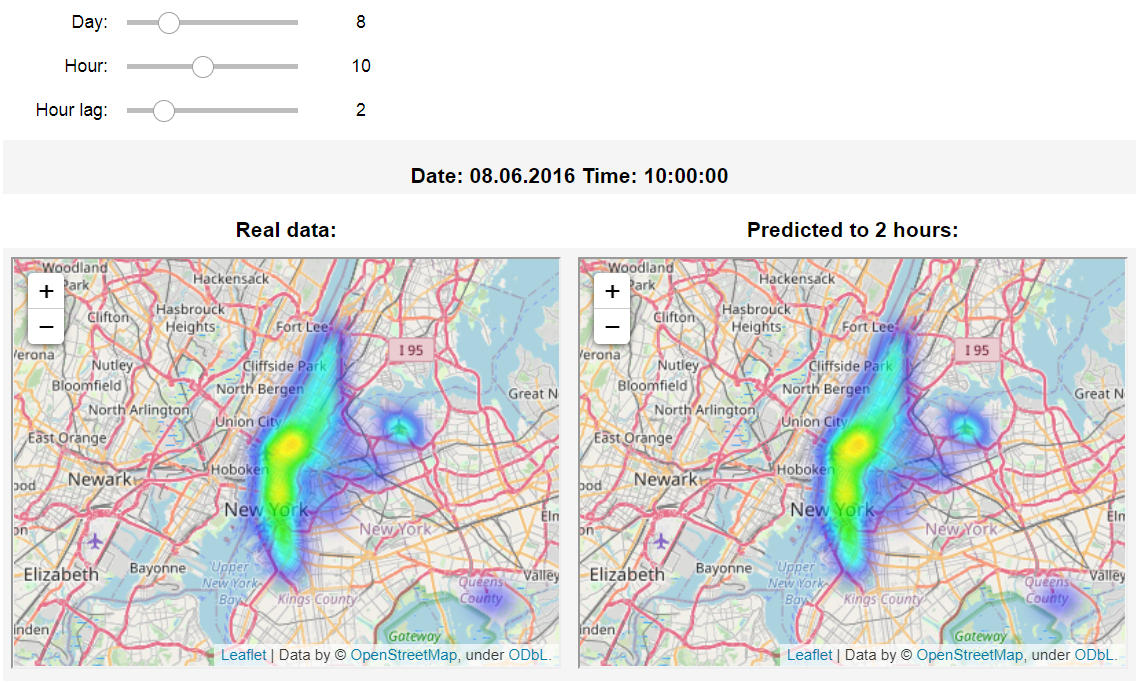

In [10]:
# The interactive graphs presented in this notebook can't be transformed correctly to PDF, so make screenshots here
Image("Data/Fig1_TaxiW7.PNG")

### 2. Time series of the real and predicted taxi demand in the selected region.

In [ ]:
# Keep for simplicity the prediction for the 1 hour time lag

In [13]:
# add the marks of all 102 regions (centers) to the map
for reg, latt, long in zip(regions['region'], regions['latt'], regions['long']):
    text = u'Region#' + str(reg)
    folium.Marker([latt, long], popup=text).add_to(map)

In [14]:
# plot the map where user can click on the region to understand its number 
map

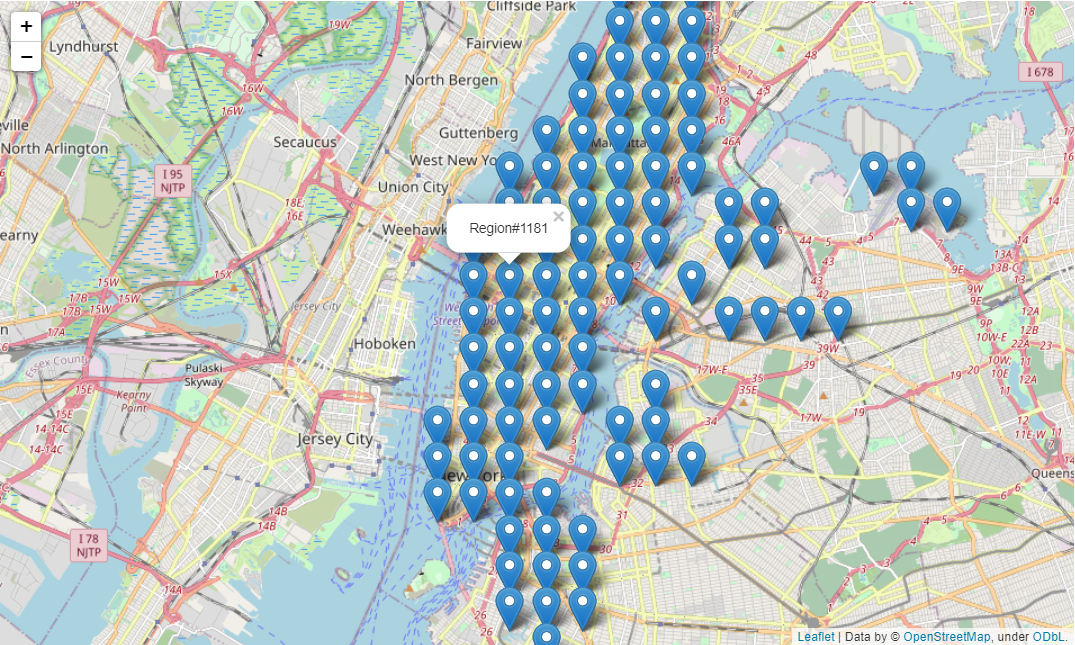

In [15]:
# The interactive graphs presented in this notebook can't be transformed correctly to PDF, so make screenshots here
Image("Data/Fig2_TaxiW7.PNG")

In [16]:
def PlotTimeSeries(reg):
    # the real trips from the region
    subdata = data[data.zone == reg]
    # construction of the predicted trips from the region:
    # take hours prediction y1 until 30.06.2016 18:00 and the rest predicted hour lags y2,y3,y4,y5,y6
    subdata_pred = dataPred[dataPred.region == reg]
    sub1 = list(subdata_pred.y1)
    sub2 = [subdata_pred.iloc[subdata_pred.shape[0]-1].y2,subdata_pred.iloc[subdata_pred.shape[0]-1].y3,
        subdata_pred.iloc[subdata_pred.shape[0]-1].y4,subdata_pred.iloc[subdata_pred.shape[0]-1].y5,
        subdata_pred.iloc[subdata_pred.shape[0]-1].y6]
    subdata_pred = sub1 + sub2

    # Make input parameters for series plot
    x = range(subdata.shape[0])
    x_labels = subdata.index.tolist()
    y = list(subdata.num_trips)
    y_pred = list(subdata_pred)

    # Make marks and graph format
    ticks = range(0, len(x), 12)
    x_ticks = [x[i] for i in ticks] + [x[len(x)-1]]
    x_labels_ticks = [x_labels[i] for i in ticks] + [x_labels[len(x_labels)-1]]
    f, (ax1) = plt.subplots(figsize=(20,10))
    ax1.set(title='Trips in June', xlabel='Departure hour', ylabel='Number of trips')
    pl_real = ax1.plot(x, y, label='Real data')
    pl_forecast = ax1.plot(x, y_pred, 'g', label='Prediction')
    plt.xticks(x_ticks, x_labels_ticks, rotation='vertical')
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    plt.show()
    
def VisualizeSeries(reg):
    if len(reg)>0:
        r = reg[0]
        PlotTimeSeries(r)

In [17]:
TimeSer = interactive(VisualizeSeries, reg=widgets.SelectMultiple(
    options=reg_list, description=u'Select the region:', disabled=False))
display(TimeSer)

interactive(children=(SelectMultiple(description='Select the region:', options=(1075, 1076, 1077, 1125, 1126, …

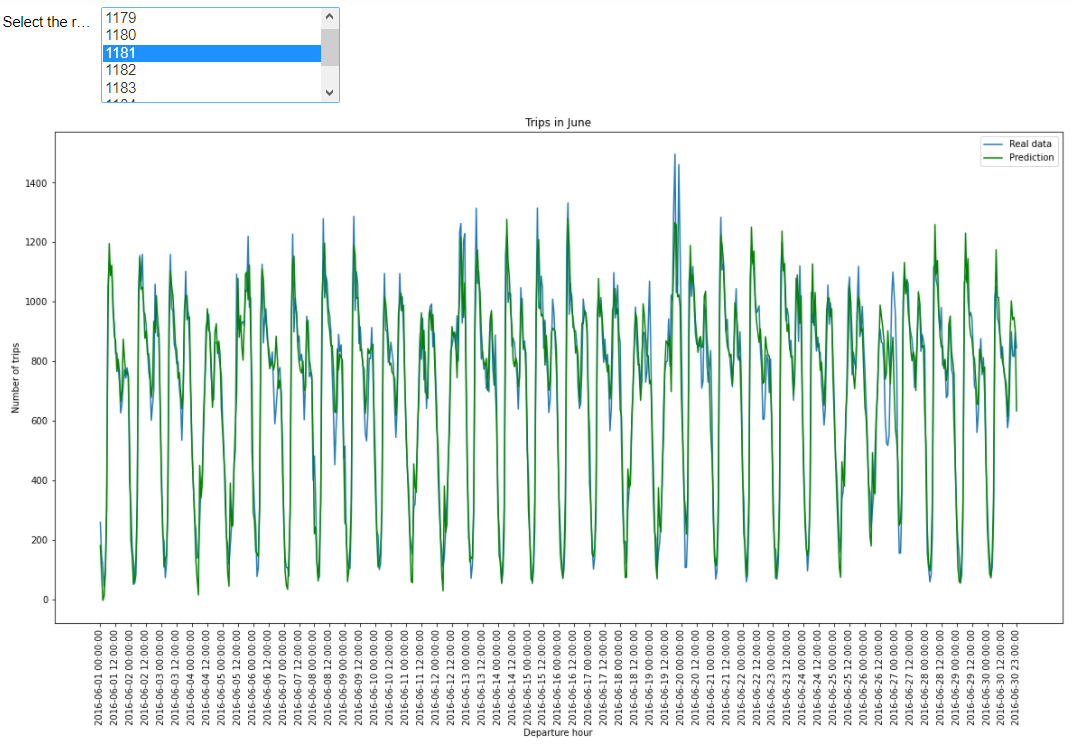

In [18]:
# The interactive graphs presented in this notebook can't be transformed correctly to PDF, so make screenshots here
Image("Data/Fig3_TaxiW7.PNG")